# Pyaudio Microphone Streaming Examples

A simple notebook that uses pyaudio to get the microphone audio and feeds this audio then to Silero VAD.

I created it as an example on how binary data from a stream could be feed into Silero VAD.


Has been tested on Ubuntu 21.04 (x86). After you installed the dependencies below, no additional setup is required.

This notebook does not work in google colab! For local usage only.

## Dependencies
The cell below lists all used dependencies and the used versions. Uncomment to install them from within the notebook.

In [1]:
# !pip install numpy>=1.24.0
# !pip install torch>=1.12.0
# !pip install matplotlib>=3.6.0
# !pip install torchaudio>=0.12.0
# !pip install soundfile==0.12.1
# !apt install python3-pyaudio #(linux) #or pip install pyaudio (windows)

## Imports

In [3]:
import io
import numpy as np
import torch
torch.set_num_threads(1)
import torchaudio
import matplotlib
import matplotlib.pylab as plt
import pyaudio

In [4]:
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /home/jr/.cache/torch/hub/master.zip


In [5]:
(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

### Helper Methods

In [6]:
# Taken from utils_vad.py
def validate(model,
             inputs: torch.Tensor):
    with torch.no_grad():
        outs = model(inputs)
    return outs

# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

## Pyaudio Set-up

In [25]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
SAMPLE_RATE = 16000
CHUNK = int(SAMPLE_RATE / 25)

audio = pyaudio.PyAudio()

## Simple Example
The following example reads the audio as 250ms chunks from the microphone, converts them to a Pytorch Tensor, and gets the probabilities/confidences if the model thinks the frame is voiced.

In [26]:
num_samples = 512

Started Recording
Stopped the recording


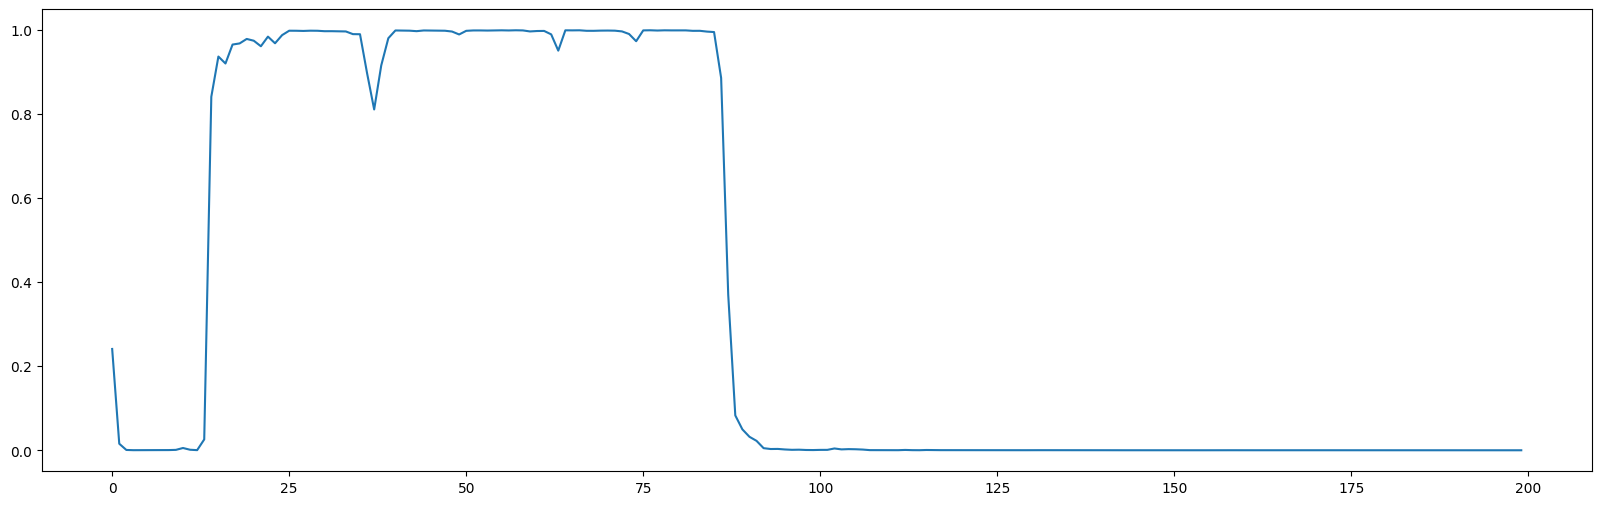

In [28]:
stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
data = []
voiced_confidences = []

#frames_to_record = 50
frames_to_record = 200

print("Started Recording")
for i in range(0, frames_to_record):
    
    audio_chunk = stream.read(num_samples)
    
    # in case you want to save the audio later
    data.append(audio_chunk)
    
    audio_int16 = np.frombuffer(audio_chunk, np.int16);

    audio_float32 = int2float(audio_int16)
    
    # get the confidences and add them to the list to plot them later
    new_confidence = model(torch.from_numpy(audio_float32), 16000).item()
    voiced_confidences.append(new_confidence)
    
print("Stopped the recording")

# plot the confidences for the speech
plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)
plt.show()

## Real Time Visualization

As an enhancement to plot the speech probabilities in real time I added the implementation below.
In contrast to the simeple one, it records the audio until to stop the recording by pressing enter.
While looking into good ways to update matplotlib plots in real-time, I found a simple libarary that does the job. https://github.com/lvwerra/jupyterplot It has some limitations, but works for this use case really well.


In [18]:
!pip install jupyterplot==0.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 968.0 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lrcurve: filename=lrcurve-1.1.0-py3-none-any.whl size=69142 sha256=bc0d9836eb08a05f487bf70d4b14e29c59e6c2d901bb0c18decdca7b052eaa95
  Stored in directory: /home/jr/.cache/pip/wheels/96/9f/d7/161ecff6abb990c666b2bdab41c36eb04f88f3922a4a02eb95
Successfully built lrcurve

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [23]:
from jupyterplot import ProgressPlot
import threading

continue_recording = True

def stop():
    input("Press Enter to stop the recording:")
    global continue_recording
    continue_recording = False

def start_recording():
    
    stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    data = []
    voiced_confidences = []
    
    global continue_recording
    continue_recording = True
    
    pp = ProgressPlot(plot_names=["Silero VAD"],line_names=["speech probabilities"], x_label="audio chunks")
    
    stop_listener = threading.Thread(target=stop)
    stop_listener.start()

    while continue_recording:
    
        audio_chunk = stream.read(num_samples)
    
        # in case you want to save the audio later
        data.append(audio_chunk)
    
        audio_int16 = np.frombuffer(audio_chunk, np.int16);

        audio_float32 = int2float(audio_int16)
    
        # get the confidences and add them to the list to plot them later
        new_confidence = model(torch.from_numpy(audio_float32), 16000).item()
        voiced_confidences.append(new_confidence)
    
        pp.update(new_confidence)


    pp.finalize()

In [24]:
start_recording()

<IPython.core.display.Javascript object>